In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import entropy
from sklearn import cluster, metrics, preprocessing

In [2]:
# Helper function to calculate Index of Coincidence
# Assumes that input text is all caps, no spaces.
def calc_shannons_entropy(text):
    # Convert ciphertext to an occurence count of each character to use in entropy formula.
    charArr = list(text)
    charSeries = pd.Series(charArr)
    charCounts = charSeries.value_counts()
    
    # Calculate.
    rv = entropy(charCounts, base=2)
    return rv

In [3]:
# Helper function to calculate Index of Coincidence
# Assumes that input text is all caps, no spaces.
def calc_ic(text):
    # Assure text exists.
    if (text == '0'):
        return 0
    
    # Define values in IC formula; assume monocase English for c.
    c = 26
    N = len(text)
    charFreqDict = Counter(text) # Alphabet character frequencies n1 through nc
    
    # Calculate.
    numerSum = 0
    for i in range(1, c + 1, 1):
        alphaChar = chr(i + 64)
        n = charFreqDict[alphaChar]
        numer = n * (n - 1)
        numerSum += numer
    # Division by c to standardize.
    denom = N * (N - 1) / c
    ic = numerSum / denom
    return ic

In [4]:
# Helper function to calculate Purity score
# Purity = % extent to which clusters contain a single, 'most common' class.
# Excerpt by user Ugurite from StackOverflow: https://stackoverflow.com/a/51672699/12881694
def calc_purity(y_true, y_pred):
    # Compute confusion matrix
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [5]:
# Cipher hyperparameters
NUM_PTS = 1000;
NUM_METHODS = 6;

# HMM hyperparameters
HMM_TRAINING_METHOD = 'vary_text_cc'
N = 7
M = 27
T = 54

In [6]:
# Import .csv files
encrypted_datasets = pd.read_csv('./cipher_datasets/encrypted_datasets_' + str(NUM_PTS) + '.csv', header=None)
encrypted_datasets = encrypted_datasets.to_numpy()

df = pd.read_csv('./cipher_datasets/' + str(NUM_PTS) + '_testoutput_N' + str(N) + '_M' + str(M) + '_T' + str(T) + '_' + HMM_TRAINING_METHOD + ".csv", header=None)
df = df.drop(df.columns[0], axis=1) # Drop first column, the headers
df = df.drop(df.columns[1000], axis=1) # Drop last column, which are all NaN
hmm_scores = df.to_numpy()

In [7]:
# Calculating Shannon's Entropy and Index of Coincidence
entropy_output = np.copy(encrypted_datasets)
ic_output = np.copy(encrypted_datasets)
for i in range(NUM_METHODS):
    j = 0
    for j in range(NUM_PTS):
        entropy_output[i][j] = calc_shannons_entropy(encrypted_datasets[i][j])  
        ic_output[i][j] = calc_ic(encrypted_datasets[i][j])
        
# Output arrays seem to be held as strings, rather than numbers. Convert them.
entropy_output = entropy_output.astype(np.float)
ic_output = ic_output.astype(np.float)
print(entropy_output)
print(ic_output)

[[3.94274567 3.94274567 3.94274567 ... 3.94274567 3.94274567 3.94274567]
 [3.94274567 3.81715337 3.42733349 ... 3.96159857 3.864375   4.01655314]
 [3.94274567 3.94274567 3.94274567 ... 3.94274567 3.94274567 3.94274567]
 [3.94274567 3.81715337 3.42733349 ... 3.96159857 3.864375   4.01655314]
 [3.94274567 3.94274567 3.94274567 ... 0.         0.         0.        ]
 [3.94274567 3.81715337 3.42733349 ... 3.96159857 3.864375   4.01655314]]
[[1.50980392 1.50980392 1.50980392 ... 1.50980392 1.50980392 1.50980392]
 [1.50980392 1.77595628 1.48571429 ... 1.57289776 1.49723145 1.47772657]
 [1.50980392 1.50980392 1.50980392 ... 1.50980392 1.50980392 1.50980392]
 [1.50980392 1.77595628 1.48571429 ... 1.57289776 1.49723145 1.47772657]
 [1.50980392 1.50980392 1.50980392 ... 0.         0.         0.        ]
 [1.50980392 1.77595628 1.48571429 ... 1.57289776 1.49723145 1.47772657]]


In [8]:
# Set coords for each method of enciphering's datapoints
vary_key_ctc_x = entropy_output[0]
vary_text_ctc_x = entropy_output[1]
vary_key_ssc_x = entropy_output[2]
vary_text_ssc_x = entropy_output[3]
vary_key_cc_x = entropy_output[4][:26]    # Only get usable data (26 alphabet charshift as keys)
vary_text_cc_x = entropy_output[5][:200] # Get rid of NaN gap left after removing training set
vary_key_ctc_y = ic_output[0]
vary_text_ctc_y = ic_output[1]
vary_key_ssc_y = ic_output[2]
vary_text_ssc_y = ic_output[3]
vary_key_cc_y = ic_output[4][:26]    # Only get usable data (26 alphabet charshift as keys)
vary_text_cc_y = ic_output[5][:200] # Get rid of NaN gap left after removing training set
vary_key_ctc_z = hmm_scores[0]
vary_text_ctc_z = hmm_scores[1]
vary_key_ssc_z = hmm_scores[2]
vary_text_ssc_z = hmm_scores[3]
vary_key_cc_z = hmm_scores[4][:26]    # Only get usable data (26 alphabet charshift as keys)
vary_text_cc_z = hmm_scores[5][:200] # Get rid of NaN gap left after removing training set


In [9]:
# Combine enciphering method pts. into single 2D array, with columns tracking features x, y, z.
vary_key_ctc = np.column_stack((vary_key_ctc_x, vary_key_ctc_y, vary_key_ctc_z))
vary_text_ctc = np.column_stack((vary_text_ctc_x, vary_text_ctc_y, vary_text_ctc_z))
vary_key_ssc = np.column_stack((vary_key_ssc_x, vary_key_ssc_y, vary_key_ssc_z))
vary_text_ssc = np.column_stack((vary_text_ssc_x, vary_text_ssc_y, vary_text_ssc_z))
vary_key_cc = np.column_stack((vary_key_cc_x, vary_key_cc_y, vary_key_cc_z))
vary_text_cc = np.column_stack((vary_text_cc_x, vary_text_cc_y, vary_text_cc_z))
xyz_pts = np.concatenate((vary_key_ctc, vary_text_ctc, vary_key_ssc, vary_text_ssc, vary_key_cc, vary_text_cc))

# Average HMM score of each enciphering method dataset.
print('Average HMM scores (in order of .csv file):')
print(np.nanmean(vary_key_ctc_z))
print(np.nanmean(vary_text_ctc_z))
print(np.nanmean(vary_key_ssc_z))
print(np.nanmean(vary_text_ssc_z))
print(np.nanmean(vary_key_cc_z))
print(np.nanmean(vary_text_cc_z))
print()

# NaN check
print('NaN count in ciphertext dataset used for HMM training: ' +str(np.count_nonzero(np.isnan(vary_key_cc))) + '\n')

# Value check
print('xyz values: \n' +str(xyz_pts))

Average HMM scores (in order of .csv file):
-4.251152060671809
-3.8840303589615433
-4.623997122126944
-3.86499569115811
-4.544985304233584
-2.2762062845224893

NaN count in ciphertext dataset used for HMM training: 0

xyz values: 
[[ 3.94274567  1.50980392 -4.08119951]
 [ 3.94274567  1.50980392 -4.0490665 ]
 [ 3.94274567  1.50980392 -4.5623329 ]
 ...
 [ 4.02507052  1.33333333 -2.70849282]
 [ 3.6771391   1.47727273 -2.03043686]
 [ 3.72853323  1.95488722 -2.64444585]]


In [10]:
# Normalizing data to be from 0~1 via feature scaling
scaled_pts, feature_norms = preprocessing.normalize(xyz_pts,axis=0,return_norm=True)

In [33]:
# Clustering hyperparameters
K = 6   # Number of clusters
RUNS = 10         # Number of parallel clustering attempts. Best cluster is chosen at end.
MAX_ITERS = 100   # Number of cluster recomputations and reassignments.
ALGO = "full"     # K-Means Variation to use
INIT = "k-means++"   # Initialization variation to use (random vs k-means++)

In [34]:
# Cluster normalized
kmeans = cluster.KMeans(init=INIT, n_clusters=K, n_init=RUNS, max_iter=MAX_ITERS, algorithm=ALGO)
kmeans.fit(scaled_pts)

KMeans(algorithm='full', max_iter=100, n_clusters=6)

In [35]:
# Cluster results
scaled_centroids = kmeans.cluster_centers_
print('Normalized Centroids: \n' +str(scaled_centroids))

# Get unnormalized centroids for graphing
centroids = np.copy(scaled_centroids)
for i in range(len(feature_norms)):
    centroids[:,i] = scaled_centroids[:,i] * feature_norms[i]
print('Denormalized Centroids: \n' + str(centroids))

# Iterations and Labels
print('Number of Iterations: ' +str(kmeans.n_iter_))
pt_labels = kmeans.labels_

# Silhouette Score = how distinct clusters are, from -1~1. Closer to 1 = better.
# Form of external validation; used for intrinsic, unsupervised clustering.
sil_score = metrics.silhouette_score(xyz_pts, pt_labels, metric='euclidean')
print('Silhouette Score: ' +str(sil_score))

# Purity Score = % extent to which clusters contain a single, 'most common' class.
# Form of internal validation; used for extrinsic, supervised clustering reliant on given labels.
true_labels = ([0]*1000) + ([1]*1000) + ([2]*1000) + ([3]*1000) + ([4]*26) + ([5]*200)
purity_score = calc_purity(true_labels, pt_labels)
print('Purity Score: ' +str(purity_score))

Normalized Centroids: 
[[ 0.01557847  0.01479786 -0.01514725]
 [ 0.01501465  0.01361912 -0.00973089]
 [ 0.01557951  0.01513286 -0.02225362]
 [ 0.01394013  0.01948109 -0.00915265]
 [ 0.0156461   0.01497004 -0.01751431]
 [ 0.01477228  0.0186996  -0.01549302]]
Denormalized Centroids: 
[[ 3.93249383  1.49744894 -4.10240459]
 [ 3.7901665   1.37816764 -2.63546507]
 [ 3.93275601  1.5313481  -6.02705972]
 [ 3.5189242   1.97136164 -2.4788592 ]
 [ 3.94956515  1.51487162 -4.74348763]
 [ 3.72898566  1.89228003 -4.19605062]]
Number of Iterations: 9
Silhouette Score: 0.3891180673988867
Purity Score: 0.4458116422148604


In [36]:
# Creating arrays of datapoints separated by on clustering classification

# Use labels to place datapoint coordinates into respective classification list as a tuple
l0,l1,l2,l3,l4,l5 = [],[],[],[],[],[]
tuple_label_arr = [l0, l1, l2, l3, l4, l5]
for i in range(len(pt_labels)):
    label = tuple_label_arr[pt_labels[i]]
    triple = (xyz_pts[i][0], xyz_pts[i][1], xyz_pts[i][2])
    label.append(triple) 
label_arr = [[],[],[],[],[],[]]

# Conversion from list of tuples to numpy array
for i in range(len(tuple_label_arr)):
    label_arr[i] = np.array(tuple_label_arr[i])
l0,l1,l2,l3,l4,l5 = label_arr[0],label_arr[1],label_arr[2],label_arr[3],label_arr[4],label_arr[5]

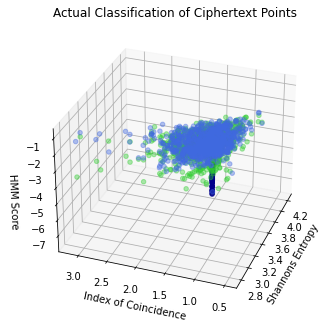

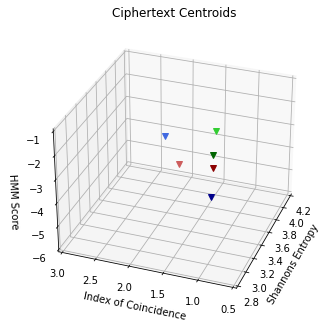

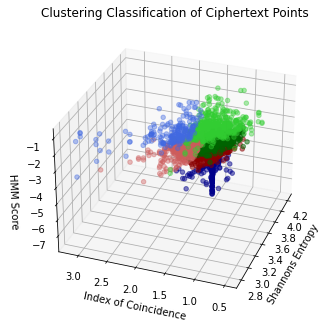

In [38]:
# Scatter points on 3D plot based on actual enciphering methods
colors = ['darkgreen', 'limegreen', 'darkblue', 'royalblue', 'darkred', 'indianred']
ax = Axes3D(plt.figure(), title='Actual Classification of Ciphertext Points', xlabel='Shannons Entropy', ylabel='Index of Coincidence', zlabel='HMM Score')
ax.scatter3D(vary_key_ctc_x, vary_key_ctc_y, vary_key_ctc_z, c=colors[0], alpha=0.5)
ax.scatter3D(vary_text_ctc_x, vary_text_ctc_y, vary_text_ctc_z, c=colors[1], alpha=0.4)
ax.scatter3D(vary_key_ssc_x, vary_key_ssc_y, vary_key_ssc_z, c=colors[2], alpha=0.5)
ax.scatter3D(vary_text_ssc_x, vary_text_ssc_y, vary_text_ssc_z, c=colors[3], alpha=0.4)
ax.scatter3D(vary_key_cc_x, vary_key_cc_y, vary_key_cc_z, c=colors[4], alpha=0.5)
ax.scatter3D(vary_text_cc_x, vary_text_cc_y, vary_text_cc_z, c=colors[5], alpha=0.4)

# Graph centroids from normalized kmeans
ax_cen = Axes3D(plt.figure(), title='Ciphertext Centroids', xlabel='Shannons Entropy', ylabel='Index of Coincidence', zlabel='HMM Score')   
for i in range(len(centroids)):
    ax_cen.plot3D([centroids[i][0]], [centroids[i][1]], [centroids[i][2]], c=colors[i], marker = "v", alpha = 1)
ax_cen.set_xlim3d(xmin=2.8, xmax=4.2)
ax_cen.set_ylim3d(ymin=0.5, ymax=3.0)
ax_cen.set_zlim3d(zmin=-6, zmax=-1)

# Scatter points on 3D plot based on clustering classification
ax2 = Axes3D(plt.figure(), title='Clustering Classification of Ciphertext Points', xlabel='Shannons Entropy', ylabel='Index of Coincidence', zlabel='HMM Score')
try:
    ax2.scatter3D(l0[:,0], l0[:,1], l0[:,2], c=colors[0], alpha=0.5)
    ax2.scatter3D(l1[:,0], l1[:,1], l1[:,2], c=colors[1], alpha=0.4)
    ax2.scatter3D(l2[:,0], l2[:,1], l2[:,2], c=colors[2], alpha=0.5)
    ax2.scatter3D(l3[:,0], l3[:,1], l3[:,2], c=colors[3], alpha=0.4)
    ax2.scatter3D(l4[:,0], l4[:,1], l4[:,2], c=colors[4], alpha=0.5)
    ax2.scatter3D(l5[:,0], l5[:,1], l5[:,2], c=colors[5], alpha=0.4)
except:
    print('Less than 6 clusters possible.')

# Rotate camera angle
deg_horiz = 200
deg_vert = 30
ax.view_init(deg_vert, deg_horiz)
ax2.view_init(deg_vert, deg_horiz)
ax_cen.view_init(deg_vert, deg_horiz)